In [1]:
import datetime
import calendar

from pycds import *
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import and_, or_
from sqlalchemy.sql import func
from sqlalchemy import funcfilter
from sqlalchemy import within_group
from sqlalchemy import select

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgpasslib

In [2]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind = engine)
session = Session()

In [3]:
year = 2000 
month = 7
day = 1
interval = 1
yr_interval = 1

start_year = datetime.datetime(year, month, day)
end_year = datetime.datetime(year + yr_interval, month, day)

start_time = datetime.datetime(year, month, day)
end_time = datetime.datetime(year, month + interval, day)

In [4]:
"""station_list = [station[0] for station in session.query(Station.id).limit(10).all()]
for station in station_list:
    print(station)
    q = session.query(Obs)\
    .filter(History.station_id == station)\
    .filter(or_(Variable.description == "Air temperature", Variable.id == 1510))\
    .filter(Variable.standard_name == "air_temperature")\
    .filter(func.extract("month", Obs.time) == 1)\
    .filter(and_(func.extract("year", Obs.time) <= end_time.year), func.extract("year", Obs.time) >= start_time.year)
    #.join(History).join(Variable)

    qid = q.first().history.station_id
    qlat = q.first().history.lat
    qlon = q.first().history.lon
    
    obs = q.all()
    #df_station = pd.read_sql(q.statement, engine)
    print(obs)"""

'station_list = [station[0] for station in session.query(Station.id).limit(10).all()]\nfor station in station_list:\n    print(station)\n    q = session.query(Obs)    .filter(History.station_id == station)    .filter(or_(Variable.description == "Air temperature", Variable.id == 1510))    .filter(Variable.standard_name == "air_temperature")    .filter(func.extract("month", Obs.time) == 1)    .filter(and_(func.extract("year", Obs.time) <= end_time.year), func.extract("year", Obs.time) >= start_time.year)\n    #.join(History).join(Variable)\n\n    qid = q.first().history.station_id\n    qlat = q.first().history.lat\n    qlon = q.first().history.lon\n    \n    obs = q.all()\n    #df_station = pd.read_sql(q.statement, engine)\n    print(obs)'

In [5]:
def baseline(start_time, end_time):
    query = session.query(Obs.datum, Obs.time, Variable.standard_name, History.station_id).filter(Obs.time <= end_time).filter(Obs.time >= start_time).join(History).join(Variable)
    return query

def precip_query(start_time, end_time):
    query = baseline(start_time, end_time).filter(Variable.standard_name == "lwe_thickness_of_precipitation_amount").filter(or_(Variable.description == "Total precipiation", Variable.id == 1397))
    return query

def temp_query(start_time, end_time):
    query = baseline(start_time, end_time).filter(Variable.standard_name == "air_temperature").filter(or_(Variable.description == "Air temperature", Variable.id == 1510))
    return query

def annual_rain(start_year, end_year, mean = True):
    yr_interval = float(np.abs(end_year.year - start_year.year))
    print(yr_interval)
    query = session.query(func.sum(Obs.datum*0.1/yr_interval).label("sum"), func.max(Obs.time).label("max_date"), History.lat, History.lon, History.station_id).group_by(History).having(func.max(Obs.time) >= end_year).filter(Variable.standard_name == "lwe_thickness_of_precipitation_amount").filter(or_(Variable.description == "Total precipiation", Variable.id == 1397))
    query = query.filter(Obs.time <= end_year).filter(Obs.time >= start_year).join(History).join(Variable)
    return query

def design_temp_25(start_time, end_time, month = 1):
    
    query = session.query(func.percentile_cont(0.025).within_group(
                    Obs.datum.asc()).label("temp"), 
                    func.min(Obs.time).label("time"),
                    History.lat,
                    History.lon,
                    History.station_id).group_by(History)\
                    .filter(or_(Variable.description == "Air temperature", Variable.id == 1510)) \
    .filter(Variable.standard_name == "air_temperature") \
    .filter(and_(func.extract("month", Obs.time) == month, func.extract("year", Obs.time) <= end_time.year)) \
    .filter(func.extract("year", Obs.time) >= start_time.year)  
    
    return query

def design_temp_1(start_time, end_time, month = 1):
    
    query = session.query(func.percentile_cont(0.01).within_group(
                    Obs.datum.asc()).label("temp"), 
                    func.min(Obs.time).label("time"),
                    History.lat,
                    History.lon,
                    History.station_id).group_by(History) \
    .filter(or_(Variable.description == "Air temperature", Variable.id == 1510)) \
    .filter(Variable.standard_name == "air_temperature") \
    .filter(and_(func.extract("month", Obs.time) == month, func.extract("year", Obs.time) <= end_time.year)) \
    .filter(func.extract("year", Obs.time) >= start_time.year)  
    
    return query

def show_design_values():
    
    query = session.query(Variable.standard_name, Variable.description, Variable.unit, Variable.id)
    
    return query

In [6]:
#q = design_temp_1(start_time, end_time)
q1 = design_temp_25(start_year, end_year, month = 1)

In [ ]:
df1 = pd.read_sql(q1.statement, engine)
%time

In [ ]:
df = df.rename(columns={'anon_1': 'July Temperature 1st Percentile'})
df1 = df1.rename(columns={'anon_1': 'July Temperature 2.5th Percentile'})

In [ ]:
sns.distplot(df['temp'], label = "1st percentile")#.hist()
sns.distplot(df1['temp'], label = "2.5th percentile")
plt.xlabel("July Temperature [0.1 C]" )
plt.legend()
plt.savefig("july_air_temp_percentiles")
plt.show()

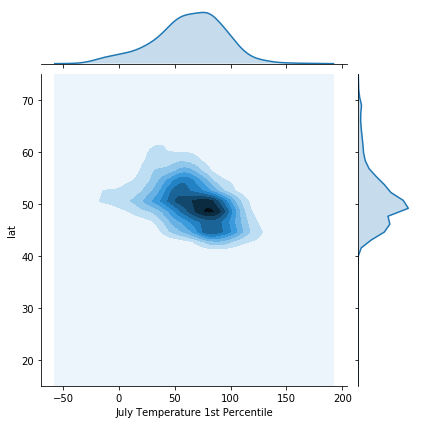

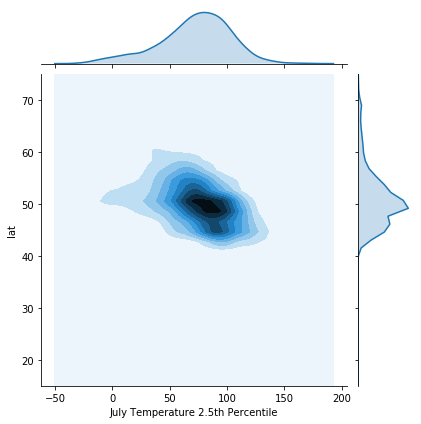

In [61]:
ax = sns.jointplot(x="temp", y="lat", kind = 'kde', data=df, label = '1st percentile')
plt.ylim(15., 75.)
plt.savefig("kde_density_1st_temp")

ax = sns.jointplot(x="temp", y="lat", kind = 'kde', data=df1, label = '2.5th percentile')
plt.ylim(15., 75.)
plt.savefig("kde_density_25th_temp")

#sns.jointplot(x="anon_1", y="lat", kind=   'kde', data=df1)
#plt.title('Joint Plot of Temp Distribution with Latitude 2nd percentile')
#plt.xlabel('Temperature [0.1 C]')
#plt.ylim(25., 75.)

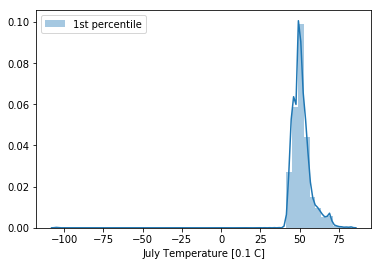

In [9]:
sns.distplot(df['lat'], label = "1st percentile")#.hist()
#sns.distplot(df1['lat'], label = "2.5th percentile")
plt.xlabel("July Temperature [0.1 C]" )
plt.legend()
plt.savefig("july_air_temp_percentiles")
plt.show()

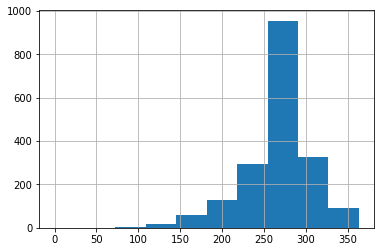

In [13]:
df['anon_1'].hist() 

In [ ]:
sns.distplot(df['datum'])
plt.xlabel('July Temperature [0.1 C]')
plt.ylabel('KDE Frequency')
plt.savefig('temp_percentile_25')

In [9]:
plt.scatter(df['lon'], df['lat'])
plt.ylim(45, 60)

KeyError: 'lon'